<a href="https://colab.research.google.com/github/shaikadish/twitterTopicModeling/blob/main/twitterTopicModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd drive/MyDrive/twitterTopicModeling

Mounted at /content/drive
/content/drive/MyDrive/twitterTopicModeling


In [ ]:
!pip install sentence_transformers
!pip install pysentimiento
!pip install pyyaml==5.4.1
!pip install umap-learn
!pip install hdbscan
!git clone https://github.com/MaartenGr/cTFIDF.git

# Get tweets

In [7]:
import json
import os
import time
import json
from requests.api import get
from datetime import datetime
import requests
import dateutil.parser as parser
from pysentimiento.preprocessing import preprocess_tweet
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def get_recent_search_query_params(search_query,start_time,end_time, max_results = 100):

    return {'query': f"{search_query} lang:en -is:retweet",
            #'granularity': granularity,
            'start_time': start_time,
            'end_time': end_time,
            'user.fields': 'id,created_at,username,name,description,location,public_metrics,url,verified,entities',
            'tweet.fields': 'author_id,in_reply_to_user_id,created_at,conversation_id,public_metrics,lang,geo,referenced_tweets,entities',
            'expansions': 'author_id',
            'max_results': max_results}

In [9]:
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAMp9TQEAAAAAmH4NuulUuo2z0lX5kaHfD4yU6u8%3Dq0Z1rZjc9GBkc7sssQ8ni1eyYz7DDtPjnWRSUxAb8iqnubyH10'
headers = {"Authorization": "Bearer {}".format(bearer_token)}

def get_recent_search_query_params(search_query,start_time,end_time, max_results = 100):
    return {'query': f"{search_query} lang:en -is:retweet",
            'start_time': start_time,
            'end_time': end_time,
            'user.fields': 'id,created_at,username,name,description,location,public_metrics,url,verified,entities',
            'tweet.fields': 'author_id,in_reply_to_user_id,created_at,conversation_id,public_metrics,lang,geo,referenced_tweets,entities',
            'expansions': 'author_id',
            'max_results': max_results}

def recent_search_lookup(search_query,granularity='day', start_time=None, end_time=None, max_count = 50) -> dict:
    url = "https://api.twitter.com/2/tweets/search/recent"

    if start_time:
       start_time = parser.parse(start_time).isoformat()+'Z'
    if end_time:
        end_time = parser.parse(end_time).isoformat()+'Z'

    params = get_recent_search_query_params('#'+' #'.join(search_query),start_time,end_time)
    all_responses = []
    response = requests.request("GET", url, headers=headers, params = params).json()
    all_responses.extend(response['data'])
    time.sleep(2)
    id_list=[]
    
    while 'next_token' in response['meta'] and len(all_responses) < max_count:
        params['next_token'] = response['meta']['next_token']
        response = requests.request("GET", url, headers=headers, params = params).json()
        
        time.sleep(2)
          
        all_responses.extend(response['data'])

    return all_responses

In [10]:
def get_tweets(hashtags,period=7,tweet_count=100):
    """
    A function to retrieve all tweets from a historical period.
    
    :param hashtags: The list of hashtags to search for
    :param period: The number of days before today to search for tweets
    """
    today=datetime.now()
    today=today.strftime("%m/%d/%Y") # Currently taking from midnight to midnight, could do some messing around to get it to be current
    begin_period=today.split('/')
    if int(begin_period[1])<=period:
        begin_period[0]=str(int(begin_period[0])-1)
        begin_period[1]=str(31-period)
    else:
        begin_period[1]=str(int(begin_period[1])-period)
    begin_period='/'.join(begin_period)
    return recent_search_lookup(hashtags,start_time=begin_period,end_time=today,max_count=tweet_count)

In [11]:
def get_text(tags,period,tweet_count):
    tweets=get_tweets(tags,period,tweet_count)
    text=[]
    stops={'emoji','url','@usuario','usuario'}
    for tweet in tweets:
      line_list=preprocess_tweet(tweet['text'],lang="en",user_token='',url_token='').split('\n')
      if line_list[0][0]=='[' and line_list[0][-1]==']':
        line_list=line_list[1:]
      new_text=' '.join(line_list)
      new_text=' '.join([word for word in new_text.split(' ') if  not(word in stops)])
      text.append(new_text)
    return text

# Topic generation

In [12]:
from matplotlib.pyplot import get
import numpy as np
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import pandas as pd
import umap
import hdbscan

In [13]:
def get_tweet_embedding(text):
    """
    A function to embed a set of tweets into an embedding space.
    
    :param text: The list of tweet texts
    :return: The set of embedding vectors
    """
    model=SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    embedding=[]
    for tweet in text:
        embedding.append(model.encode(tweet))
    embedding=np.array(embedding)
    return embedding

In [14]:
def get_topic_labels(vectors,min_cluster_size):
    """
    A function to uncover the topics present in a text embedding.
    
    :param vectors: A set of embedding vectors
    :return: The uncovered topics and their associated scores
    """
    fit=umap.UMAP(n_components=5,n_neighbors=15,metric='cosine')
    reduced_data=fit.fit_transform(vectors)
    cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(reduced_data)
    fit=umap.UMAP(n_components=3,n_neighbors=15,metric='cosine')
    reduced_data=fit.fit_transform(vectors)
    result=pd.DataFrame(reduced_data,columns=['x','y','z'])
    result['labels']=cluster.labels_
    clustered=result.loc[result.labels!=-1]
    ax=plt.axes(projection='3d')
    ax.scatter3D(clustered.x,clustered.y,clustered.z,c=clustered.labels)
    return cluster.labels_

In [15]:
def get_tweet_label_df(text,min_cluster_size):
  tweet_embeddings=get_tweet_embedding(text)
  labels=get_topic_labels(tweet_embeddings,min_cluster_size)
  data={'tweet':text,'label':labels}
  return pd.DataFrame(data=data)

In [ ]:
text=get_text(['f1'],6,100)
tweets_with_topics=get_tweet_label_df(text,5)

# Topic Processing

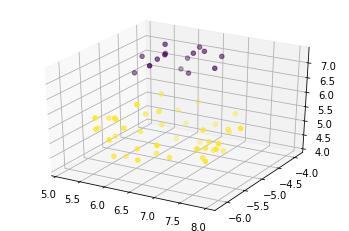

In [17]:
biggest_topic=tweets_with_topics.label.value_counts().index[0]
new_text=tweets_with_topics.tweet[tweets_with_topics.label==biggest_topic].to_list()
tweets_with_topics=get_tweet_label_df(new_text,5)

In [18]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from cTFIDF.ctfidf import CTFIDFVectorizer
from nltk.corpus import stopwords
from transformers import AutoTokenizer,AutoModelForSequenceClassification
# Get data and create documents per label)
docs_per_class = tweets_with_topics.groupby(['label'],as_index=False).agg({"tweet":' '.join})
for doc in docs_per_class.iterrows():
  doc=doc[1]
  new_corpus=[]
  for word in doc.tweet.split(' '):
    if not(word in stopwords.words('english')):
      new_corpus.append(word)
  docs_per_class.loc[docs_per_class.label==doc.label,'tweet']=' '.join(new_corpus)
  print(docs_per_class.loc[docs_per_class.label==doc.label,'tweet']==' '.join(new_corpus))

# Create c-TF-IDF
count_vectorizer = CountVectorizer().fit(docs_per_class.tweet)
count=count_vectorizer.transform(docs_per_class.tweet)
words=count_vectorizer.get_feature_names()

ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(tweets_with_topics)).toarray()
words_per_class = {str(label): [words[index] for index in ctfidf[label].argsort()[-10:]] for label in docs_per_class.label}

0    True
Name: tweet, dtype: bool
1    True
Name: tweet, dtype: bool
2    True
Name: tweet, dtype: bool


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
words_per_class

{'-1': ['ferrari',
  '1st',
  'racing',
  'face',
  'formula1',
  'gp',
  'medal',
  'place',
  'monaco',
  'f1'],
 '0': ['goal',
  'design',
  'puntos',
  'contradicts',
  'team',
  'formula1',
  'leclerc',
  'sainz',
  'keycap',
  'f1'],
 '1': ['also',
  'message',
  'radio',
  'mercedes',
  'gp',
  'spain',
  'race',
  'f1',
  'hamilton',
  'spanish']}

In [20]:
def get_sentiment(text):
    """
    A function to predict the sentiment of a piece of text.
    
    :param text: The text
    :return: The sentiment score
    """
    tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis",)
    model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
    inputs=tokenizer(text,return_tensors='pt',truncation=True)
    outputs=model(**inputs) 
    
    return [i.item() for i in outputs.logits[0]]

In [22]:
class_tweets=tweets_with_topics.tweet[tweets_with_topics['label']==1].to_list()
for tweet in class_tweets:
    print(get_sentiment(tweet))

[-3.6978931427001953, 1.6764079332351685, 1.8113933801651]
[-2.7472574710845947, 3.1421403884887695, -0.661849319934845]
[-3.647023916244507, 2.7276573181152344, 0.6097016334533691]
[-2.9676496982574463, 3.070754051208496, -0.3687995672225952]
[0.7283925414085388, 0.5049409866333008, -1.19920814037323]
[-3.1480753421783447, -0.8031018972396851, 3.8523221015930176]
[-3.957709550857544, 2.116098403930664, 1.5668796300888062]
[-2.961211919784546, 3.198166847229004, -0.4541253447532654]
[-3.0695443153381348, 1.6270157098770142, 1.2767003774642944]
[-3.6215767860412598, 2.814391613006592, 0.5412060022354126]
[-3.6303274631500244, -0.11368804425001144, 3.5996921062469482]
[1.4479947090148926, 1.4267221689224243, -2.812985420227051]
[-2.1383142471313477, 3.1413166522979736, -1.2322527170181274]
[-3.6098554134368896, 2.534252405166626, 0.8162674307823181]
[-4.055661678314209, 1.310545802116394, 2.5317933559417725]
[-2.8438005447387695, -1.0959733724594116, 3.8693113327026367]


KeyboardInterrupt: ignored